# Lecture 30: Linear Regression

In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## Review of correlation

In [2]:
hybrid = Table.read_table('hybrid.csv')
hybrid.show(3)

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact


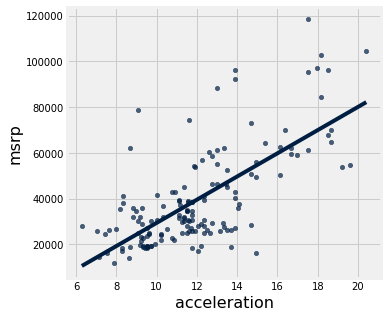

In [3]:
# Visualize: is there a linear relationship between two variables?
hybrid.scatter('acceleration', 'msrp', fit_line=True)

In [4]:
def standard_units(numbers):
    "Convert any array of numbers to standard units."
    return (numbers - np.mean(numbers)) / np.std(numbers)  

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

In [5]:
# Quantify: how scattered are the points around a straight line?
correlation(hybrid, 'acceleration', 'msrp')

0.6955778996913978

## Properties of correlation

**1. Unaffected by changing units**

In [6]:
accel_msrp = hybrid.select('acceleration', 'msrp')
correlation(accel_msrp, 'acceleration', 'msrp')

0.6955778996913978

In [7]:
accel_msrp_su = standardize(accel_msrp)
correlation(accel_msrp_su, 'acceleration (su)', 'msrp (su)')

NameError: name 'standardize' is not defined

In [8]:
accel_msrp_1k = accel_msrp.with_column(
    'msrp ($k)', accel_msrp.column('msrp') / 1000
)
correlation(accel_msrp_1k, 'acceleration', 'msrp ($k)')

0.6955778996913979

Because we're measuring the **relative** spread around a straight line.

NameError: name 'accel_msrp_su' is not defined

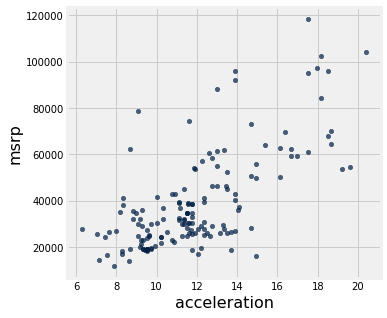

In [9]:
accel_msrp.scatter('acceleration', 'msrp')
accel_msrp_su.scatter('acceleration (su)', 'msrp (su)')
accel_msrp_1k.scatter('acceleration', 'msrp ($k)')

**2. Unaffected by swapping variables**

In [10]:
correlation(hybrid, 'acceleration', 'msrp')

0.6955778996913978

In [11]:
correlation(hybrid, 'msrp', 'acceleration')

0.6955778996913978

Because the roles of $x$ and $y$ are symmetric in formula, and graphs are symmetric when you swap axes.

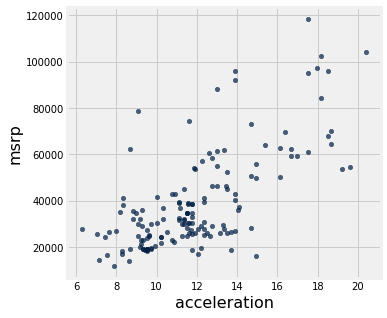

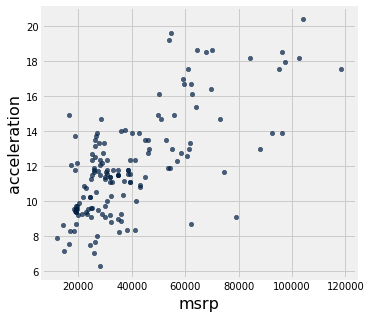

In [12]:
accel_msrp.scatter('acceleration', 'msrp')
accel_msrp.scatter('msrp', 'acceleration')

## A little justification for the correlation formula

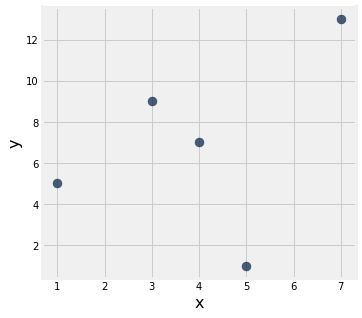

In [13]:
# some toy data
t = Table().with_columns(
    'x', make_array(1,3,4,5,7),
    'y', make_array(5,9,7,1,13)
)
t
t.scatter('x', 'y', s=80)

In [14]:
correlation(t, 'x', 'y')

0.4

In [15]:
# let's plot in standard units
# recall it's just the axes that change, not the relative positions of the data points

t_su = standardize(t)
t_su.scatter('x (su)', 'y (su)', s=80)

NameError: name 'standardize' is not defined

In [16]:
# plot the data with the size of each dot proportional
# to the product that dot contributes to the formula

t_su_prod = t_su.with_columns(
    'product', t_su.column('x (su)') * t_su.column('y (su)'),
    'abs product', np.abs(t_su.column('x (su)') * t_su.column('y (su)'))
)
t_su_prod.scatter('x (su)', 'y (su)', sizes='abs product', labels='product', s=100)
plots.xlim(-3, 3);
plots.ylim(-3, 3);
plots.plot([-3, 3], [0,0], color='blue', linestyle='dashed');
plots.plot([0,0], [-3,3], color='blue', linestyle='dashed');
plots.text(2, 2, '+', fontsize=48);
plots.text(-2.5, 2, '-', fontsize=64);
plots.text(-2.75, -2.5, '+', fontsize=48);
plots.text(2.25, -2.5, '-', fontsize=64);

NameError: name 't_su' is not defined

* Because axes are in standard units, $+$ quadrants have positive products, and $-$ quadrants have negative products
* $r$ is the average of those labels on the dots
* More big dots in $+$ quadrants brings $r$ closer to $1$
* More big dots in $-$ quadrants brings $r$ closer to $-1$
* Dots relatively spread out brings $r$ closer to $0$

## Prediction using correlation

In [17]:
galton = Table.read_table('galton.csv')
heights = galton.select('midparentHeight', 'childHeight')\
  .relabeled('midparentHeight', 'MidParent')\
  .relabeled('childHeight', 'Child')
heights.show(3)

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69


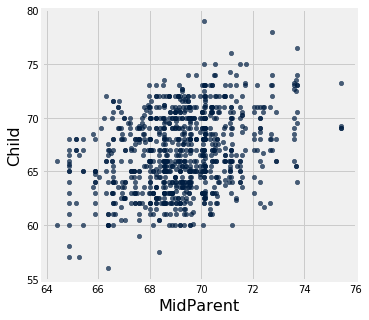

In [18]:
heights.scatter('MidParent')

In [19]:
def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

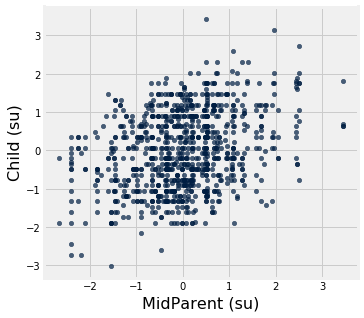

In [20]:
heights_su = standardize(heights)
heights_su.scatter('MidParent (su)')

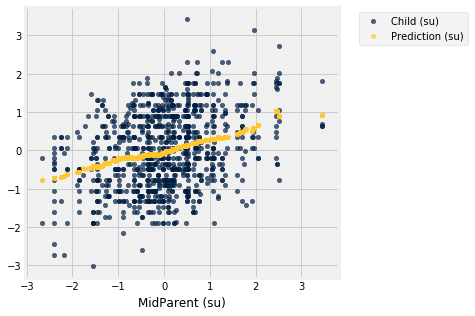

In [21]:
def predict_child_su(new_midparent_height):
    close_points = heights_su.where('MidParent (su)', 
                                are.between(new_midparent_height - 0.5, 
                                            new_midparent_height + 0.5))
    return close_points.column('Child (su)').mean()    

heights_su_pred = heights_su.with_column(
    'Prediction (su)', heights_su.apply(predict_child_su, 'MidParent (su)')
)
heights_su_pred.scatter('MidParent (su)')

The yellow line is the *graph of averages*.

**Q:** What is the predicted height (in su) of a child whose parents have an average height?

A. -1  
B. 0  
C. 1  
D. Whatever $r$ is for this scatter plot  
E. Can't answer from this plot  

<br/><br/><br/><br/><br/><br/>

In [22]:
r = correlation(heights, 'MidParent', 'Child')
r

0.32094989606395924

## The graph of averages and $r$

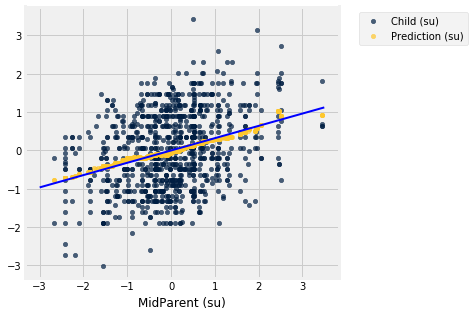

In [23]:
heights_su_pred.scatter('MidParent (su)')

# plot the line "y = r * x"
plots.plot([-3, 3.5], [-3*r, 3.5*r], color='blue', lw=2);

The line $y = r \times x$ is a version of the graph of averages, smoothed to a line.

## Regression to the mean

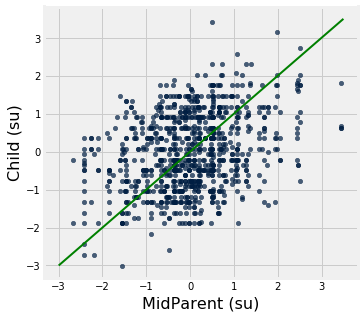

In [24]:
heights_su.scatter('MidParent (su)')

# Plot the "SD line"
plots.plot([-3, 3.5], [-3, 3.5], color='green', lw=2);

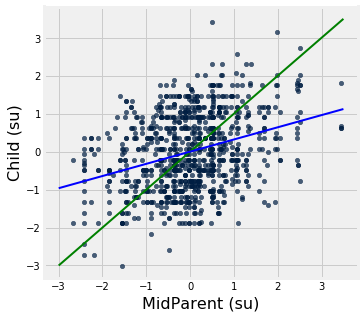

In [25]:
heights_su.scatter('MidParent (su)')

# Plot the "SD line"
plots.plot([-3, 3.5], [-3, 3.5], color='green', lw=2);

# plot the regression line "y = r * x"
plots.plot([-3, 3.5], [-3*r, 3.5*r], color='blue', lw=2);

Regression line is flatter than SD line:  extreme values of $x$ result in not-as-extreme values of $y$

## Prediction by linear regression

In [26]:
parent_mean = np.mean(heights.column('MidParent'))
parent_sd = np.std(heights.column('MidParent'))
child_mean = np.mean(heights.column('Child'))
child_sd = np.std(heights.column('Child'))
print('Parent: mean =', parent_mean, '; SD =', parent_sd)
print(' Child: mean =', child_mean, '; SD =', child_sd)
print('     r:', r)

Parent: mean = 69.20677301927195 ; SD = 1.8014050969207571
 Child: mean = 66.74593147751605 ; SD = 3.5773346010057634
     r: 0.32094989606395924


In [27]:
def predict_with_r(parent):
    """Return a prediction of the height of a child whose parents 
    have a midparent height of mp, using linear regression.
    """
    parent_su = (parent - parent_mean) / parent_sd
    child_su = r * parent_su
    return child_su * child_sd + child_mean

In [28]:
def predict_with_average(parent):
    """"Return a prediction of the height of a child whose parents 
    have a midparent height of mp, using the average of nearby parents.
    """
    close_points = heights.where('MidParent', 
                                are.between(parent - 0.5, 
                                            parent + 0.5))
    return close_points.column('Child').mean()  

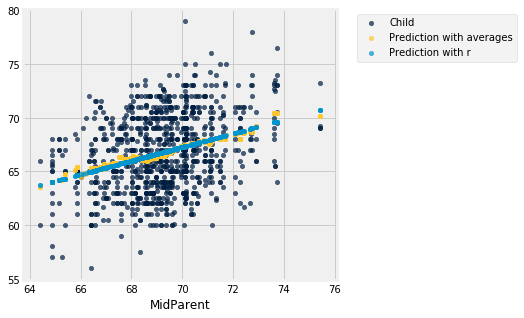

In [29]:
heights.with_columns(
    'Prediction with averages', heights.apply(predict_with_average, 'MidParent'),
    'Prediction with r', heights.apply(predict_with_r, 'MidParent')
).scatter('MidParent')

## Slope and Intercept

In [30]:
def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

In [31]:
predict_with_r(74)

69.80094692533119

In [32]:
def predict_with_slope_and_intercept(x):
    s = slope(heights, 'MidParent', 'Child')
    i = intercept(heights, 'MidParent', 'Child')
    return s * x + i

In [33]:
predict_with_slope_and_intercept(74)

69.8009469253312